In [2]:
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
prices = []

df = pd.read_csv('/content/new_AAPL.csv')

col = list(df)[0]

df_for_training = df[col].astype(float)

time_steps = np.arange(0, len(series), step=1)

series = np.array(df_for_training)
time = np.array(time_steps)

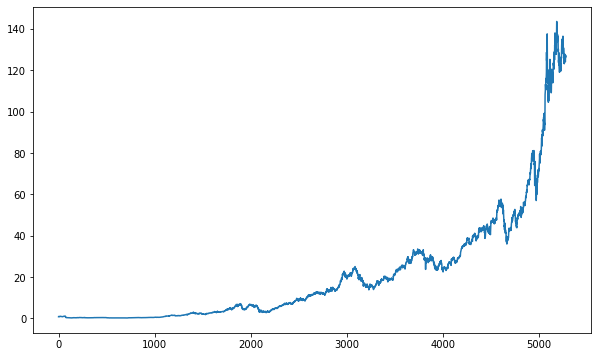

In [59]:
plt.figure(figsize=(10,6))
plt.plot(time, series)

In [78]:
split_time = 4000
train_time = time[:split_time]
train_data = series[:split_time]
test_time = time[split_time:]
test_data = series[split_time:]

In [79]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [80]:
def windowed_data(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [81]:
train_data = windowed_data(series, window_size, batch_size, shuffle_buffer_size)

In [67]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, 
                         kernel_size=5, 
                         strides=1, 
                         padding='causal', 
                         activation='relu', 
                         input_shape=(None, 1)),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
])

model.compile(loss='MAE',
              optimizer='adam',
              metrics='MAE')

history = model.fit(train_data, epochs=100)

Epoch 1/100
165/165 [==============================] - 11s 40ms/step - loss: 4.1687 - MAE: 4.1687
Epoch 2/100
165/165 [==============================] - 6s 37ms/step - loss: 1.7591 - MAE: 1.7591
Epoch 3/100
165/165 [==============================] - 6s 38ms/step - loss: 0.8012 - MAE: 0.8012
Epoch 4/100
165/165 [==============================] - 6s 38ms/step - loss: 0.8983 - MAE: 0.8983
Epoch 5/100
165/165 [==============================] - 6s 38ms/step - loss: 0.7980 - MAE: 0.7980
Epoch 6/100
165/165 [==============================] - 6s 38ms/step - loss: 0.6243 - MAE: 0.6243
Epoch 7/100
165/165 [==============================] - 6s 37ms/step - loss: 1.1973 - MAE: 1.1973
Epoch 8/100
165/165 [==============================] - 6s 37ms/step - loss: 0.8202 - MAE: 0.8202
Epoch 9/100
165/165 [==============================] - 6s 37ms/step - loss: 0.5666 - MAE: 0.5666
Epoch 10/100
165/165 [==============================] - 6s 38ms/step - loss: 0.5877 - MAE: 0.5877
Epoch 11/100
165/165 [======

In [82]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [83]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

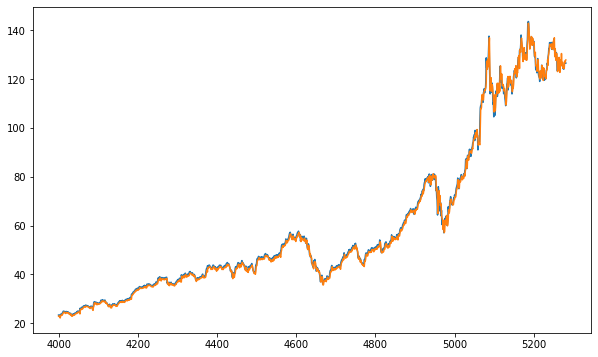

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(test_time, test_data)
plt.plot(test_time, rnn_forecast)

In [91]:
tf.keras.metrics.mean_absolute_error(test_data, rnn_forecast).numpy()

0.9949274

In [93]:
print(rnn_forecast - test_data)

[-0.47093346 -0.42528359 -0.15966003 ... -0.3773574   0.55523646
  1.29965951]
